<a href="https://colab.research.google.com/github/SongXihao-Alan/Tic-Tac-Toe/blob/main/tic_tac_toe_Version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Module**

In [1]:
from __future__ import absolute_import, division, print_function



In [2]:
'''
This is the version running in HPC, if you want to run in colab, please intall the following module.
'''

!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install imageio>=2.5,<3.0 --upgrade
!pip install imageio imageio-ffmpeg
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install tf-agents[reverb]
!pip install pyglet
!pip install pydot graphviz

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [673 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,751 kB]
Get:13 http://archive.ub

In [3]:

import gym
import base64
import unittest
import IPython
import logging
import matplotlib
import pandas as pd
import reverb
import numpy as np  # 这是python中常用的指令，调用库numpy并在以后重命名为np
import matplotlib.pyplot as plt # 这是python中常用的指令，调用库matplotlib重的pyplot模块并在以后重命名为plt
import tensorflow as tf # 调用tensorflow库
import random
import time  # Only needed if you want to artificially slow down the loop
import collections

from gym import spaces
from IPython.display import Video
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from tf_agents import utils
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import py_environment
from tf_agents.environments import utils
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.eval.metric_utils import log_metrics
from tf_agents.networks import sequential
from tf_agents.networks import network
from tf_agents.networks import q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
from tf_agents.specs import array_spec
from tf_agents.utils import common
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from collections import deque
from tqdm import tqdm



In [4]:
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
#this code is for google colab only and necessary when you want to download the vedio.
from google.colab import files
from collections import deque


## **Environment**

In the env.class, it represent the tic-tac-toe game in 9x9 board, the rule is following:

It is the varison of game (9,9,4) which means player will win if they have a line of 4. The action is the grid_action.

The chosen square is accepted with probability = 1/2.   If not accepted, the other 8 nearby squares are chosen with probability 1/8* (1/2). If the choice of the computer is occupied or outside of the board, the player’s move is forfeited.

We design the reward function with two pars: firstly, if the action result a winning state, then the reward is 1 and his opponent gets -1, if it is draw, the reward is 0. Second part is the stage_reward, if the action result in almost_win_state which contains a line of 3, then the player receive a smaller reward, 0.1.

In [5]:
class TicTacToeEnv(gym.Env):

    """
    This class represents an environment for a modified Tic-Tac-Toe game with random elements.
    The game is played on a 9x9 grid, and each player aims to align four of their marks in a row.
    """
    metadata = {'render.modes': ['human']}

    """
    Initializes the Tic-Tac-Toe environment.
    """

    def __init__(self):
        super(TicTacToeEnv, self).__init__()
        self.board_size = 9 # The length of the board
        self.win_length = 4 # The length of the line needed to win
        self.action_space = spaces.Discrete(self.board_size**2)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.board_size, self.board_size), dtype=np.int8)# Define Observation space with 9x9 grid, range of element is -1, 0, 1.

        # Define state_size and action_size
        self.state_size = self.board_size * self.board_size  # Total number of cells in the board
        self.action_size = self.action_space.n  # Total number of possible actions

        self.state = None # Attribute of the enviornment class to None means the enivornment is an unintialized state
        self.current_player = 1 # First player's turn
        self.reset()#start a new game by resetting the environment to a default state
        self.reward = 0

    """
    Resets the environment to its initial state for a new game.
    Returns:
    numpy.ndarray: The initial state of the game board (empty board).
    """
    def reset(self):
        self.state = np.zeros((self.board_size, self.board_size), dtype=np.int8) # self.state is assigned a new Numpy 9x9 array of zeros.
        self.current_player = 1 # First player's turn for whatever the new game starts
        self.reward = 0
        return self.state  #returns the initial state of the environment, the empty game board


    """
    Executes a step in the environment given an action.
    Returns:
    tuple: A tuple containing the new state, reward, done flag, and additional info.
    """
    def step(self, action):
        row, col = divmod(action, self.board_size)

       #  Random move adjustment
        if np.random.rand() < 0.5:
            neighbors = self.get_neighbors(row, col)
            if neighbors:
                row, col = neighbors[np.random.choice(len(neighbors))]
         #row, col now is the actual move (either intented move or random move), If the move is invalid, switch players and return
        if not self.is_valid_move(row, col):
            self.current_player *= -1
            winner = None
            done = winner is not None or not np.any(self.state == 0)
            return self.state, self.reward, done, {}

        self.state[row, col] = self.current_player
        winner = self.check_winner()
        if self.almost_winning(self.current_player, row, col):
            self.reward += 0.1  # Small positive reward for almost winning
        done = winner is not None or not np.any(self.state == 0)
        self.reward += self.calculate_reward(winner)
        # Switch players for the next turn
        self.current_player *= -1

        return self.state, self.reward, done, {}


    """
    Finds the neighboring cells around a given cell.
    Returns:
        list: A list of tuples representing the neighboring cells.
    """
    def get_neighbors(self, row, col):
        neighbors = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue  # Skip the original cell
                new_row, new_col = row + dr, col + dc
                neighbors.append((new_row, new_col))
        return neighbors

    def is_on_board(self, row, col):
        return 0 <= row < self.board_size and 0 <= col < self.board_size #returns True if both the row and column indices are within the range of 0 to self.board_size - 1.

    def is_valid_move(self, row, col): #determines if a move to a given cell is valid.
        return self.is_on_board(row, col) and self.state[row, col] == 0

    """
    Closes the Tic-Tac-Toe environment and releases resources.
    """
    def close(self):
        if self.some_resource:  # Check if a certain resource is initialized
            self.some_resource.close()  # Properly close or release the resource
        if self.graphical_interface:  # Check if a graphical interface is used
            self.graphical_interface.destroy()  # Close or destroy the interface

        if self.network_connection:  # Check if there's an open network connection
            self.network_connection.close()  # Close the network connection
        print("Tic-Tac-Toe environment resources have been released.")
        print("Closing Tic-Tac-Toe environment.")

    '''
    Win condition
    '''
    def check_winner(self):
    # Check rows, columns, and diagonals for a win
        for row in range(self.board_size):
            for col in range(self.board_size):
                if self.state[row, col] != 0:  # For each cell that is not empty
                # Checking all eight directions
                    if (self.check_line(row, col, 1, 0) or  # Horizontal (right)
                        self.check_line(row, col, 0, 1) or  # Vertical (down)
                        self.check_line(row, col, 1, 1) or  # Diagonal (down-right, ↘)
                        self.check_line(row, col, -1, 1) or  # Diagonal (up-right, ↗)
                        self.check_line(row, col, -1, -1) or  # Diagonal (up-left, ↖)
                        self.check_line(row, col, 1, -1) or  # Diagonal (down-left, ↙)
                        self.check_line(row, col, -1, 0) or  # Vertical (up)
                        self.check_line(row, col, 0, -1)):  # Horizontal (left)
                        return self.state[row, col]
        return None

    """
    Check a line of pieces in the board.
    """
    def check_line(self, start_row, start_col, d_row, d_col): #start_row and start_col specify the starting cell, and d_row and d_col specify the direction to check in.
        end_row = start_row + (self.win_length - 1) * d_row
        end_col = start_col + (self.win_length - 1) * d_col
        if 0 <= end_row < self.board_size and 0 <= end_col < self.board_size:
            for i in range(self.win_length): #If any cell in this line does not match the player number in the starting cell, it returns False
                if self.state[start_row + i * d_row, start_col + i * d_col] != self.state[start_row, start_col]:
                    return False
            return True
        return False

    def calculate_reward(self, winner):
        if winner is None:
            return 0  # No winner yet, or it's a draw
        elif winner == 1:
            return 1  # Player 1 wins, reward is 1
        else:
            return -1  # Player 2 wins, reward is -1

    """
    Returns a list of possible moves based on the current state.

    Returns:
        list: A list of indices representing possible moves.
    """
    def getPossibleMoves(self):
        return [i for i in range(self.board_size ** 2) if self.is_valid_move(*divmod(i, self.board_size))]

    def almost_winning(self, player, last_move_row, last_move_col):
    # Check in all eight directions from the last move
        for d_row, d_col in [(1, 0), (0, 1), (1, 1), (-1, 1), (-1, -1), (1, -1), (-1, 0), (0, -1)]:
            count = 0  # Count of consecutive marks
            for i in range(-2, 3):  # Check two cells in both directions
                row, col = last_move_row + i * d_row, last_move_col + i * d_col
                if not (0 <= row < self.board_size and 0 <= col < self.board_size):
                    continue  # Skip if the cell is out of the board
                if self.state[row, col] == player:
                    count += 1
                    if count == 3:  # Found 3 in a row
                        return True
                else:
                    count = 0  # Reset count if a different mark is encountered
        return False

    # visually rendering the current state of the Tic-Tac-Toe board in the console.
    def render(self, mode='human', close=False):
        if mode == 'rgb_array':
            return self.render_rgb_array()
        else:
            # Correctly indented code block for 'human' mode rendering
            h_line = "+---" * self.board_size + "+"
            print(h_line)
            for row in self.state:
                row_str = "|" + "|".join(' X ' if cell == 1 else ' O ' if cell == -1 else '   ' for cell in row) + "|"
                print(row_str)
                print(h_line)
            if close:
                self.close()

    def render_rgb_array(self):
        # Create an image of the board state
        data = np.zeros((self.board_size, self.board_size, 3), dtype=np.uint8)
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.state[i, j] == 1:
                    data[i, j] = [255, 0, 0]  # Red for player 1
                elif self.state[i, j] == -1:
                    data[i, j] = [0, 0, 255]  # Blue for player 2

        # Convert array to image and resize for better visibility
        img = cv2.resize(data, (300, 300), interpolation=cv2.INTER_NEAREST)
        return img

    def close(self):
        if self.some_resource:  # Check if a certain resource is initialized
            self.some_resource.close()  # Properly close or release the resource
        if self.graphical_interface:  # Check if a graphical interface is used
            self.graphical_interface.destroy()  # Close or destroy the interface

        if self.network_connection:  # Check if there's an open network connection
            self.network_connection.close()  # Close the network connection
        print("Tic-Tac-Toe environment resources have been released.")
        print("Closing Tic-Tac-Toe environment.")



### **Test**

This is test of env.class, it contains the move, check_winner, check_almost_winning, reward.

In [21]:
# Create an instance of the environment
env = TicTacToeEnv()
print("Current Player before the move:", "Player 1" if env.current_player == 1 else "Player 2")
# Define a board state where player 1 is one move away from winning horizontally
env.state = np.array([
    [ 1,  1,  1,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
])

# Print the current board state before the move
print("Board State Before the Move:")
env.render()

# Winning action for player 1 is to place a marker in the empty spot (row 0, column 3)
winning_action_for_player_1 = 0 * env.board_size + 3  # Convert 2D coordinate to 1D action index

# Perform the action
new_state, reward, done, info = env.step(winning_action_for_player_1)

# Print the board state after the move
print("Board State After the Move:")
env.render()

# Check the result
winner = env.check_winner()
print("Winner:", "Player 1" if winner == 1 else "Player 2" if winner == -1 else "No winner")
print("Reward:", reward)
# Assert the result (this will raise an error if the assertion is false)
assert winner == 1, "Player 1 should have won"
print("Current Player before the move:", "Player 1" if env.current_player == 1 else "Player 2")

Current Player before the move: Player 1
Board State Before the Move:
+---+---+---+---+---+---+---+---+---+
| X | X | X |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
Board State After the Move:
+---+---+---+---+---+---+---+---+---+
| X | X | X | X |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---

In [22]:
# Create an instance of the environment
env.reset()
env = TicTacToeEnv()
env.current_player = -1
print("Current Player before the move:", "Player 1" if env.current_player == 1 else "Player 2")
# Define a board state where player 1 is one move away from winning horizontally
env.state = np.array([
    [ -1,  -1,  -1,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
])


# Print the board state before the winning move
print("Board State Before the Move (Player 2):")
env.render()

# Print the current board state before the move
print("Board State Before the Move:")
env.render()

# Winning action for player 2 is to place a marker in the empty spot (row 0, column 3)
winning_action_for_player_2 = 0 * env.board_size + 3  # Convert 2D coordinate to 1D action index

print(winning_action_for_player_2)

# Perform the action for player 2
new_state, reward, done, info = env.step(winning_action_for_player_2)
print(new_state)

# Print the board state after the winning move
print("Board State After the Move (Player 2):")
env.render()

# Check and print the winner
winner = env.check_winner()
print("Winner:", "Player 1" if winner == 1 else "Player 2" if winner == -1 else "No winner")
print("reward", reward)
# Assert the result
assert winner == -1, "Player 2 should have won"
print("Current Player before the move:", "Player 1" if env.current_player == 1 else "Player 2")


Current Player before the move: Player 2
Board State Before the Move (Player 2):
+---+---+---+---+---+---+---+---+---+
| O | O | O |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
Board State Before the Move:
+---+---+---+---+---+---+---+---+---+
| O | O | O |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---

In [23]:
# Create an instance of the environment
env = TicTacToeEnv()

# Normal Move
action = env.board_size * 5 + 5  # Convert 2D coordinate (5,5) to action
env.step(action)
# Check the updated state, neighbors, etc.

# Move when cell is taken
env.reset()
env.state[5, 4] = 1  # Mark cell (5,4) as taken
env.step(action)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8),
 0,
 False,
 {})

## **Hyperparameter**

In [14]:
buffer_size = 600000  # 指定了重播缓冲区的最大长度。重播缓冲区用于存储过去的经验，以便代理可以从中学习。
batch_size = 128 #指定了从重播缓冲区中提取的每个批次的大小，以进行训练。
learning_rate_actor=0.05
learning_rate_critic= 0.05  # 学习率，影响了模型权重的更新速度。

learning_rate_actor_NPC=0.01
learning_rate_critic_NPC= 0.01  # 学习率，影响了模型权重的更新速度。


update_interval = 50
gamma = 0.99
total_episodes = 500  # 训练次数

epsilon_start = 0.99
epsilon_decay = 0.95
epsilon_min = 0.01

grid_action_size = 81  # 9x9 Tic-Tac-Toe board
full_state_size = 81
max_energy = 10

## **Network**

This porject uses two neural network architectures: the Actor and Critic networks: the Actor network proposes actions given the state of the environment, while the Critic network evaluates these actions.

Actor Network
Purpose: To propose actions based on the current state. It handles both discrete (grid position) and continuous (energy level) action spaces.

Critic Network
Purpose: To evaluate the proposed actions from the Actor network, taking into account the current state of the environment.

Actor Network:




### **Actor Network**

In [7]:
'''
Actor Network
The Actor network's role is to propose actions given the current state of the environment.
Discrete Action Output: A probability distribution over the grid positions.
Continuous Action Output: A value representing the energy level to use.
'''


class Actor(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='LeakyReLU', input_shape=(state_size,))
        #self.batch_norm1 = tf.keras.layers.BatchNormalization()

        self.dense2 = tf.keras.layers.Dense(64, activation='LeakyReLU')
        #self.batch_norm2 = tf.keras.layers.BatchNormalization()

        self.dense3_grid_action = tf.keras.layers.Dense(81, activation='LeakyReLU')
        #self.batch_norm3_grid_action = tf.keras.layers.BatchNormalization()

        self.grid_action = tf.keras.layers.Dense(action_size, activation='softmax')


    def call(self, state):
        x = self.dense1(state)
        #x = self.batch_norm1(x)

        x = self.dense2(x)
        #x = self.batch_norm2(x)

        x_grid_action = self.dense3_grid_action(x)
        #x_grid_action = self.batch_norm3_grid_action(x_grid_action)

        grid_action_probs = self.grid_action(x_grid_action)

        return grid_action_probs

### **Critic Network**

In [8]:
'''
The Critic network evaluates the actions taken by the Actor by predicting the expected returns (Q-values) of the state-action pairs.
The Critic takes both the state and the action as input and outputs a single Q-value.
'''
class Critic(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.grid_action_size = action_size
        self.state_dense = tf.keras.layers.Dense(64, activation='LeakyReLU', input_shape=(state_size,))
        #self.state_batch_norm = tf.keras.layers.BatchNormalization()

        # Save these sizes as attributes
        self.grid_action_dense = tf.keras.layers.Dense(128, activation='LeakyReLU')
        self.concat_layer = tf.keras.layers.Concatenate()

        self.dense2 = tf.keras.layers.Dense(128, activation='LeakyReLU')
        #self.batch_norm2 = tf.keras.layers.BatchNormalization()

        self.output_layer = tf.keras.layers.Dense(1, activation='linear')

    def call(self, state, grid_action):
        state_path = self.state_dense(state)
        #state_path = self.state_batch_norm(state_path)

        # Use the saved attribute sizes here
        grid_action = tf.reshape(grid_action, [-1, self.grid_action_size])
        grid_action_path = self.grid_action_dense(grid_action)

        combined = self.concat_layer([state_path, grid_action_path])
        x = self.dense2(combined)
        #x = self.batch_norm2(x)

        return self.output_layer(x)


## **Replay Buffer**

In [9]:

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


## **Actor-Critic Agent**

In [10]:
# Actor-Critic Agent

class ActorCriticAgent:
    def __init__(self, state_size, action_size, buffer_size, batch_size, learning_rate_actor, learning_rate_critic, gamma, epsilon_start, epsilon_decay, epsilon_min, update_interval):
        self.full_state_size = state_size
        self.grid_action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.update_interval = update_interval
        self.step_counter = 0
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.actor = Actor(state_size, action_size)
        self.critic = Critic(state_size, action_size)
        self.target_critic = Critic(state_size, action_size)
        self.target_critic.set_weights(self.critic.get_weights())

        self.actor_optimizer = RMSprop(learning_rate=learning_rate_actor)
        self.critic_optimizer = RMSprop(learning_rate=learning_rate_critic)

        self.memory = ReplayBuffer(buffer_size)


    def act(self, state):
        if np.random.rand() <= self.epsilon:
         #Choose a random action
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            return random_policy(env)
        else:
        # Predict action based on policy
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            state = np.reshape(state, [1, self.full_state_size])
            grid_action_probs = self.actor(state)

            # Get sorted indices of grid_action_probs in descending order
            sorted_indices = np.argsort(grid_action_probs.numpy()[0])[::-1]
            for grid_action in sorted_indices:
                if env.is_valid_move(*divmod(grid_action, env.board_size)):
                    return (grid_action)
            # If no valid action found using argmax, fall back to random policy
            return random_policy(env)


    def remember(self, state, action, reward, next_state, done):
        # Ensure grid action is stored in one-hot encoded format
        one_hot_grid_action = np.zeros((1, self.grid_action_size))
        #one_hot_grid_action[0, action[0]] = 1
        one_hot_action = (one_hot_grid_action)  # action[1] is energy action
        self.memory.add(state, one_hot_action, reward, next_state, done)

    def replay(self):
        minibatch = self.memory.sample(self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, [1, self.full_state_size])
            next_state = np.reshape(next_state, [1, self.full_state_size])

            grid_action = action
            grid_action = np.reshape(grid_action, [1, -1])  # Reshape for processing

            # Critic update
            target_action_grid = self.actor(next_state)
            target_critic_val = self.target_critic(next_state, target_action_grid)
            critic_target = reward + (self.gamma * target_critic_val * (1 - int(done)))

            with tf.GradientTape() as tape:
                current_critic_val = self.critic(state, grid_action)
                critic_loss = tf.keras.losses.MSE(critic_target, current_critic_val)
            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

            # Actor update
            with tf.GradientTape() as tape:
                actions_grid = self.actor(state)
                critic_value = self.critic(state, actions_grid)
                actor_loss = -tf.math.reduce_mean(critic_value)
            actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

            self.step_counter += 1
            if self.step_counter % self.update_interval == 0:
                self.update_target_models()

    def update_target_models(self):
        self.target_critic.set_weights(self.critic.get_weights())

    def save(self, path):
        # Save the actor and critic models
        self.actor.save_weights(f'{path}_actor.h5')
        self.critic.save_weights(f'{path}_critic.h5')

    def load(self, path):
        # Load the actor and critic models
        self.actor.load_weights(f'{path}_actor.h5')
        self.critic.load_weights(f'{path}_critic.h5')


In [12]:
def random_policy(env):
    # Generate a valid grid action
    possible_action =  env.getPossibleMoves()
    grid_action = random.choice(possible_action) if possible_action else None

    return (grid_action)

## **Evaluate**

Now, evaluate the performance by play between two same agents one is 'agent' and the other is 'NPC'. Both two have same agent construct and network.

The winning probability for first player is appraoching 90% quickly (around 500 episodes) and increase slowly afterword (i.e., aroun 91.4% after 1000 episodes).

In [11]:
def create_video(frames, filename='training_video.mp4', fps=10):
    if not frames:
        print("No frames to create video.")
        return
    height, width, _ = frames[0].shape
    video = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for frame in frames:
        video.write(frame)
    video.release()

In [15]:
# Evaluation
env = TicTacToeEnv()
agent = ActorCriticAgent(env.state_size, env.action_size, buffer_size, batch_size, learning_rate_actor, learning_rate_critic, gamma, epsilon_start, epsilon_decay, epsilon_min, update_interval)
NPC = ActorCriticAgent(env.state_size, env.action_size,  buffer_size, batch_size, learning_rate_actor_NPC, learning_rate_critic_NPC, gamma, epsilon_start, epsilon_decay, epsilon_min, update_interval)
# Evaluation
player_1_wins, player_2_wins, draws = 0, 0, 0  # Reset the win/draw counters
# Variables for plotting
win_rate_version2,draw_rate_version2,lose_rate_version2,x_axis_version2 = [], [], [], []

frames = []
all_frames = []  # To store frames for the complete video


for episode in range(total_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.state_size])
    player_turn = 1
    episode_frames = []  # To store frames for the current episode
    while True:
        epsilon = agent.epsilon
        current_player = env.current_player  # Get the current player from the environment
        if current_player == 1:  # Actor-Critic Agent (Player 1)
            chosen_grid_action = agent.act(state)  # Get the chosen grid action and energy
            chosen_grid_action = int(chosen_grid_action)
            action = (chosen_grid_action)

        else:  # Random Policy (Player -1)
            chosen_grid_action = NPC.act(state)  # Get the chosen grid action and energy
            chosen_grid_action = int(chosen_grid_action)
            action = (chosen_grid_action)

        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, env.state_size])
        if current_player == 1:
            agent.remember(state, action, reward, next_state, done)
        else:
            NPC.remember(state, action, reward, next_state, done)

        frame = env.render(mode='rgb_array')
        if frame is not None:
            episode_frames.append(frame)
        all_frames.append(frame)  # Also add to the complete video frames list
        # Update the state for the next iteration
        state = next_state

        if done:
            winner = env.check_winner()
            if winner == 1:
                player_1_wins += 1
            elif winner == -1:
                player_2_wins += 1
            else:
                draws += 1
            break
            # Replay and Update the target model
    print(epsilon)
    #print(len(agent.memory))
    if len(agent.memory) > agent.batch_size:
       agent.replay()
    if len(NPC.memory) > NPC.batch_size:
       NPC.replay()
    # Update and statistics
    total_rounds = episode + 1
    win_rate_version2.append(player_1_wins / total_rounds)
    draw_rate_version2.append(draws / total_rounds)
    lose_rate_version2.append(player_2_wins / total_rounds)
    x_axis_version2.append(total_rounds)

    print(f"Episode {episode + 1}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")

print(f"Episode {total_rounds}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")

0.30428329904777335
Episode 1: Player 1 Wins - 0, Player 2 Wins - 1, Draws - 0, Reward - -0.20000000000000007
0.11482239908700545
Episode 2: Player 1 Wins - 1, Player 2 Wins - 1, Draws - 0, Reward - 1.3
0.05319621052291285
Episode 3: Player 1 Wins - 1, Player 2 Wins - 2, Draws - 0, Reward - -0.8
0.03185053626756927
Episode 4: Player 1 Wins - 1, Player 2 Wins - 3, Draws - 0, Reward - -0.7
0.012018914603248726
Episode 5: Player 1 Wins - 2, Player 2 Wins - 3, Draws - 0, Reward - 1.4
0.009789481062562356
Episode 6: Player 1 Wins - 3, Player 2 Wins - 3, Draws - 0, Reward - 1.4
0.009789481062562356
Episode 7: Player 1 Wins - 4, Player 2 Wins - 3, Draws - 0, Reward - 1.7999999999999998
0.009789481062562356
Episode 8: Player 1 Wins - 5, Player 2 Wins - 3, Draws - 0, Reward - 1.2
0.009789481062562356
Episode 9: Player 1 Wins - 6, Player 2 Wins - 3, Draws - 0, Reward - 1.4
0.009789481062562356
Episode 10: Player 1 Wins - 7, Player 2 Wins - 3, Draws - 0, Reward - 1.2
0.009789481062562356
Episode 

In [17]:
# Create a complete video after all episodes
if all_frames:
    create_video(all_frames, filename='complete_training_video_version2.mp4')
    print("Complete training video created")
else:
    print("No frames to create the complete video.")

Complete training video created


## **Plot**

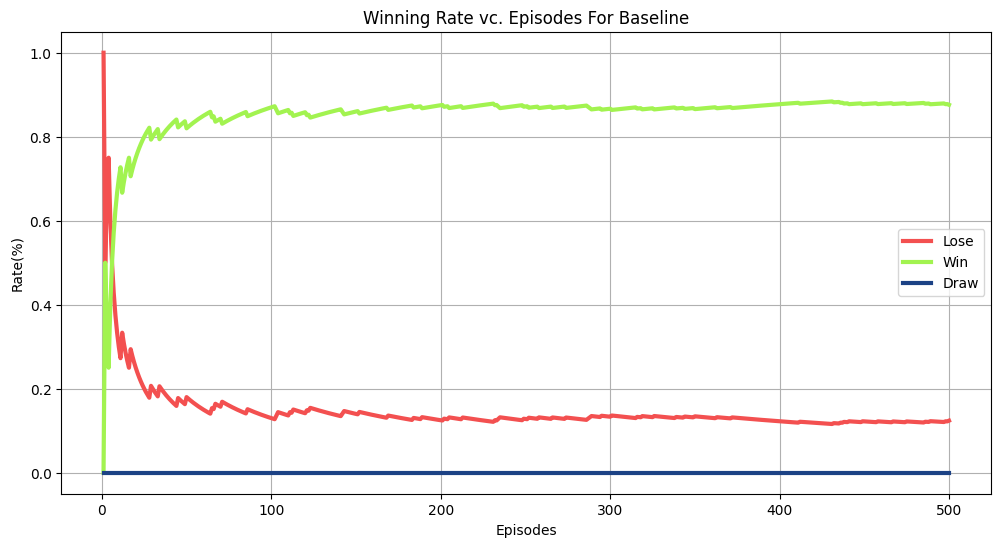

In [16]:

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(x_axis_version2, lose_rate_version2, label='Lose', linewidth = 3, color = '#F35050')  # Plot the lose rate
plt.plot(x_axis_version2, win_rate_version2, label='Win', linewidth = 3, color = '#A2F350')  # Plot the win rate
plt.plot(x_axis_version2, draw_rate_version2, label='Draw', linewidth = 3, color = '#1c4285')  # Plot the draw rate
plt.xlabel('Episodes')  # Label for x-axis
plt.ylabel('Rate(%)')  # Label for y-axis
plt.title('Winning Rate vc. Episodes For Baseline')  # Title of the plot
plt.legend()  # Add a legend
plt.grid(True)  # Add grid for better readability
plt.savefig('winning_rate_version2_plot.png')  # Save the second plot as a PNG file
plt.show()  # Display the plot



## **Vedio**

This will download the vedio of training.

In [18]:
# Training Loop with Video Capturing
files.download('complete_training_video_version2.mp4')  # Adjust filename as needed

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Save Result**

This will save the data of result for each episode.

In [19]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Assuming DDQNAgent and TicTacToeEnv are defined and initialized

In [20]:
# save data
data_compare_version2 = {
    'Episodes': x_axis_version2,
    'Win Rate': win_rate_version2,
    'Lose Rate': lose_rate_version2,
    'Draw Rate': draw_rate_version2
}
df_compare_version2 = pd.DataFrame(data_compare_version2)
df_compare_version2.to_csv('winning_rate_baseline_data_version2.csv', index=False)  # Save as CSV